<a href="https://colab.research.google.com/github/StanleyLiangYork/DeepLearningForMalaria/blob/master/inception_net_implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import numpy as np
import os
from matplotlib import pyplot as plt

print(tensorflow.__version__)

2.2.0-rc2


170500096/170498071 [==============================] - 4s 0us/step


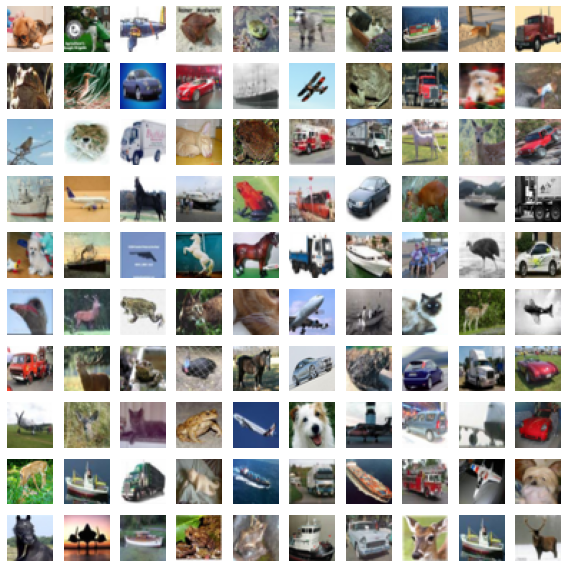

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

ROWS = 10
x = x_train.astype('uint8')
fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(8,8))

for i in range(ROWS):
  for j in range(ROWS):
    idx = np.random.choice(range(len(x)))
    axes1[i][j].axis('off')
    axes1[i][j].imshow(x[idx:idx+1][0])

plt.tight_layout()
plt.show()


In [0]:
nRows,nCols,nDims = x_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

In [0]:
def define_inception_net():
  
  inputs = Input(shape=(32,32,3))

  # the first inception block
  # first inception layer
  x1 = Conv2D(30, (1,1), padding='same', activation='relu')(inputs)
  x1 = Conv2D(30, (3,3), padding='same', activation='relu')(x1)
  x1 = Dropout(0.2)(x1)
  #x1 = BatchNormalization()(x1)

  x2 = Conv2D(30, (1,1), padding='same', activation='relu')(inputs)
  x2 = Conv2D(30, (5,5), padding='same', activation='relu')(x2)
  x2 = Dropout(0.2)(x2)
  #x2 = BatchNormalization()(x2)
  
  x3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(inputs)
  x3 = Conv2D(30, (1,1), padding='same', activation='relu')(x3)
  x3 = Dropout(0.2)(x3)
  #x3 = BatchNormalization()(x3)

  merge_1 = tensorflow.keras.layers.concatenate([x1, x2, x3], axis = 3)
  merge_1 = BatchNormalization()(merge_1)
  merge_1 = Dropout(0.4)(merge_1)

  x = Flatten()(merge_1)
  x = Dense(1000, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)
  x = Dense(500, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(250, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

  y = Dense(nClasses, activation='softmax')(x)
  model = Model(inputs=[inputs], outputs=y)
  return model


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 30)   120         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 30)   120         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 3)    0           input_1[0][0]                    
______________________________________________________________________________________________

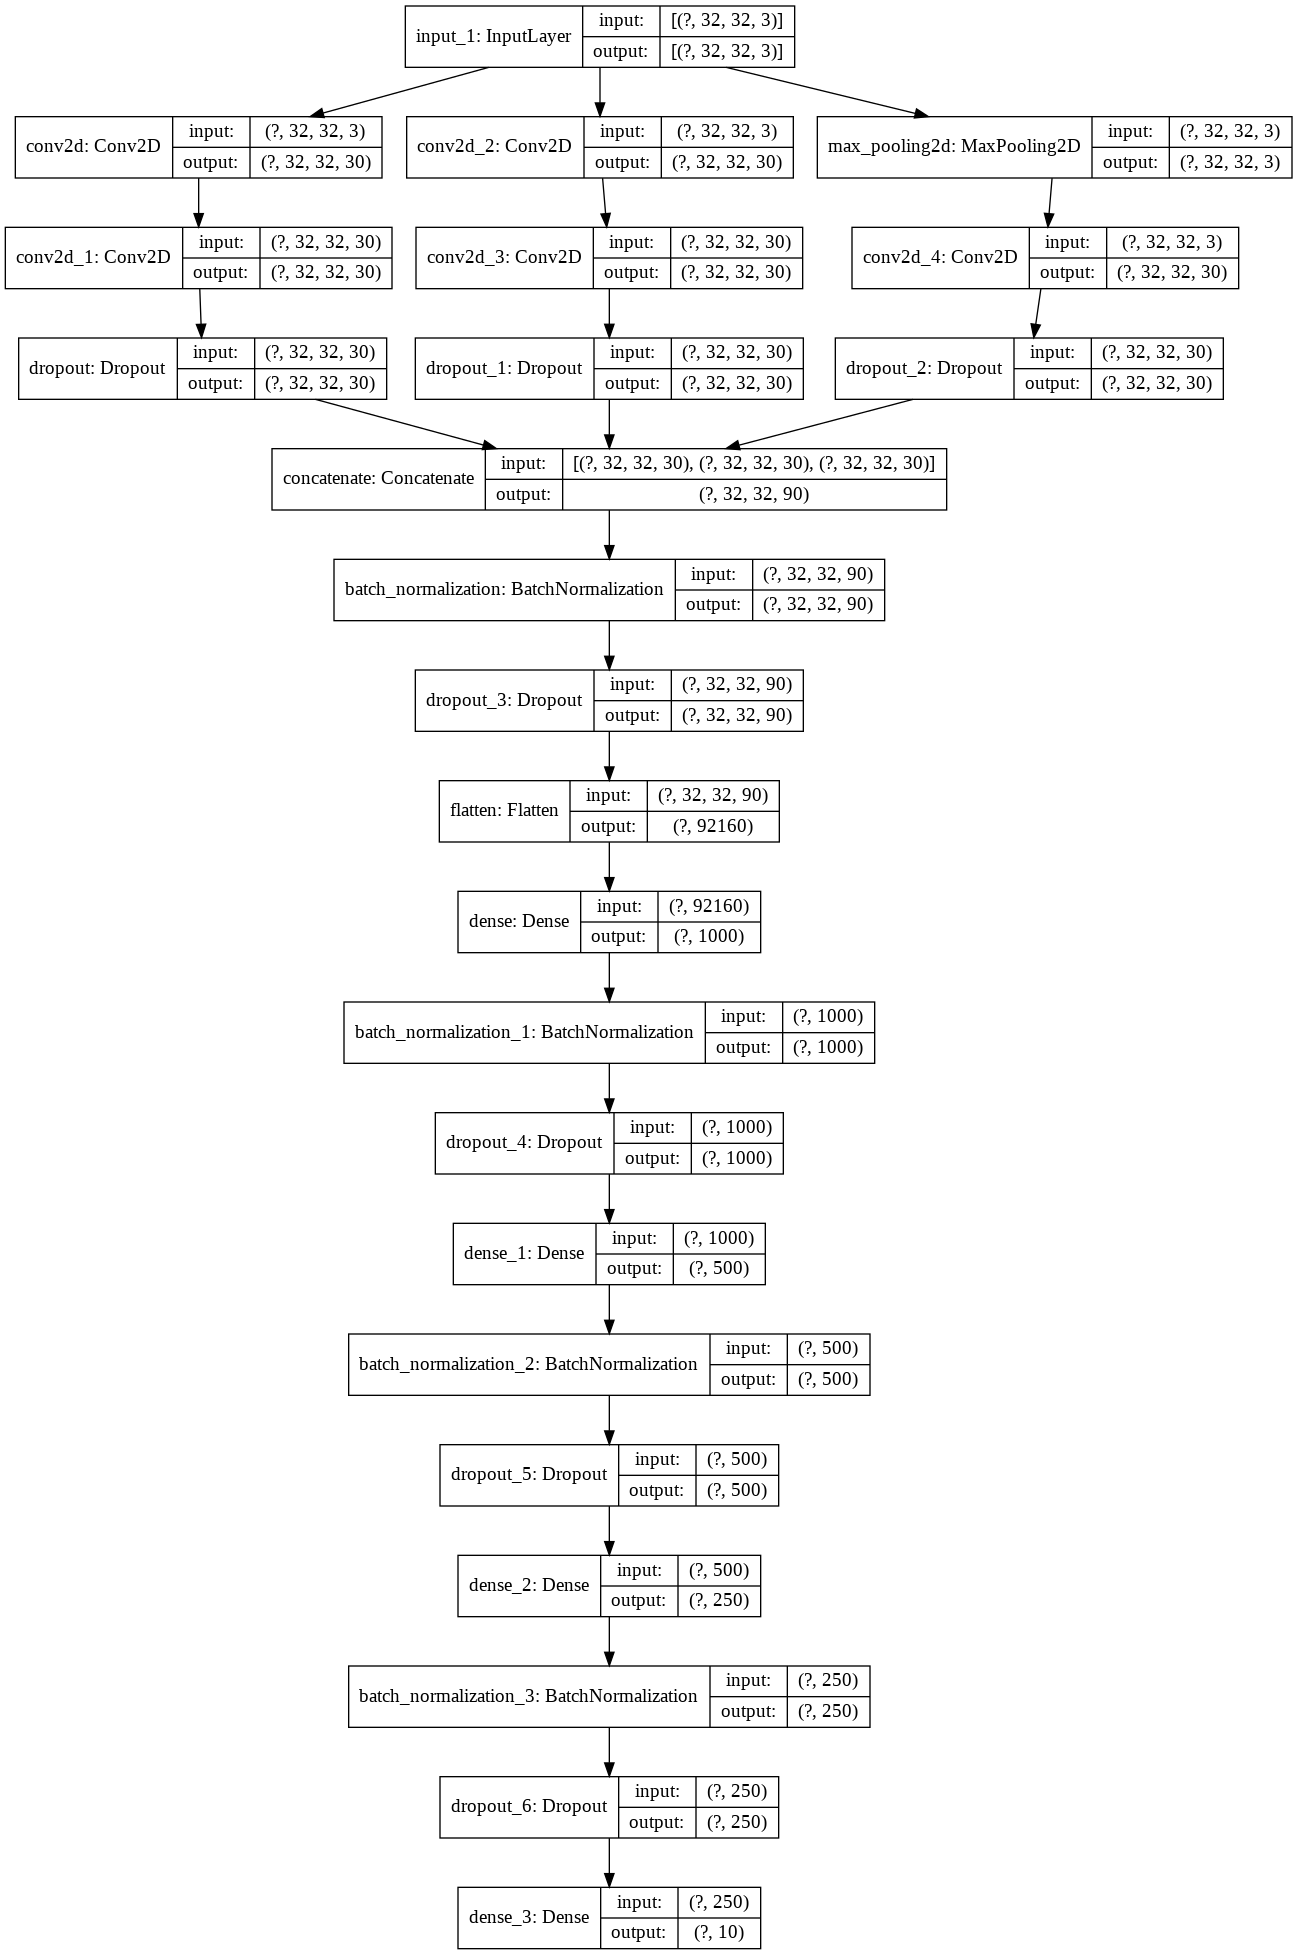

In [5]:
model = define_inception_net()
model.summary()
plot_model(model, to_file='inceptionNet.png', show_shapes=True, show_layer_names=True)

In [0]:
def lr_schedule(epoch):
  lr = 1e-3
  if epoch > 180:
    lr *= 0.5e-3
  elif epoch > 160:
    lr *= 1e-3
  elif epoch > 120:
    lr *= 1e-2
  elif epoch > 80:
    lr *= 1e-1
  print('Learning rate: ', lr)
  return lr

In [7]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Learning rate:  0.001


In [8]:
# Normalize data.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# subtract pixel mean to zero-center
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

NUM_CLASSES = 10

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def summarize_diagnostics(history):
  plt.figure(figsize=(10, 10))
  # plot loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], color='blue', label='Training')
  plt.plot(history.history['val_loss'], color='orange', label='Test')
  plt.legend(loc='lower right')
  plt.title('Cross Entropy Loss')
  # plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], color='blue', label='Training')
  plt.plot(history.history['val_accuracy'], color='orange', label='Test')
  plt.legend(loc='lower right')
  plt.title('Classification Accuracy')
  plt.show()

In [0]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

Learning rate:  0.001
Epoch 1/200
98/98 [==============================] - 10s 102ms/step - loss: 1.8164 - accuracy: 0.3917 - val_loss: 2.1893 - val_accuracy: 0.2593 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
98/98 [==============================] - 10s 97ms/step - loss: 1.3014 - accuracy: 0.5375 - val_loss: 2.1053 - val_accuracy: 0.2957 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
98/98 [==============================] - 10s 97ms/step - loss: 1.0727 - accuracy: 0.6183 - val_loss: 1.8127 - val_accuracy: 0.3367 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
98/98 [==============================] - 10s 97ms/step - loss: 0.8760 - accuracy: 0.6879 - val_loss: 1.4711 - val_accuracy: 0.4648 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
98/98 [==============================] - 10s 97ms/step - loss: 0.7104 - accuracy: 0.7502 - val_loss: 1.3746 - val_accuracy: 0.5258 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
98/98 [==============================] - 9s 97ms/step - loss: 0.5536 - accu

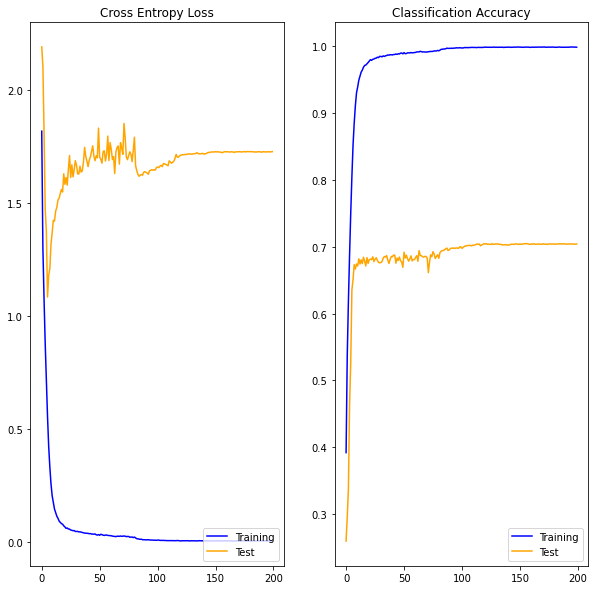

In [11]:
callbacks = [lr_reducer, lr_scheduler]

history = model.fit(x_train, y_train,batch_size=512,epochs=200,validation_data=(x_test, y_test),shuffle=True,callbacks=callbacks)
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("loss: {:6.3f}, accuracy: {:6.3f}%".format(loss, acc*100))
summarize_diagnostics(history)